# Render RHS

In [ ]:
#| default_exp render_rhs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Overview
The searching phase of rewrite is done, so now we have a filtered ResultSet which we'll use for the transformation part.
Since we might want to change each matched graph a bit differently, depending on the actual values of its attributes, we allow the user to define a parameterized RHS string:

For each placeholder in the string, the user writes "{{name_of_placeholder}}" inside the string.
In this module, we wrap the string with jinja2's Template class and render the string with a dictionary, sent by the user to the rewrite function as **render_rhs** - a dictionary whose keys are names of templated arguments in RHS, and values are functions that receive a Match and return a new value (dependent on the current matches). For every match, we calculate the actual value that the functions specify for each template argument, and render the RHS accordingly, such that every match has its own specific RHS string.

### Requirements

In [ ]:
#| export
import copy
import networkx as nx
from lark import Transformer, Lark
from lark import UnexpectedCharacters, UnexpectedToken
from graph_rewrite.match_class import Match
from graph_rewrite.core import GraphRewriteException
from graph_rewrite.core import _create_graph, _plot_graph, _graphs_equal
from graph_rewrite.lhs import RenderFunc, graphRewriteTransformer

### P Grammar

In [ ]:
#| export
p_parser = Lark(r"""
    %import common.WS -> WS
    %ignore WS

    NAMED_VERTEX: /[a-zA-Z0-9\*]+/
    ATTR_NAME: /[a-zA-Z0-9]+/
    INDEX: /[0-9]+/
        
    attribute: ATTR_NAME
    attributes: "[" attribute ("," attribute)* "]"

    connection: ["-" attributes]"->"
    
    index_vertex: NAMED_VERTEX "<" INDEX ("," INDEX)* ">"

    vertex: NAMED_VERTEX [attributes]
    | index_vertex [attributes]

    pattern: vertex (connection vertex)*
    patterns: pattern (";" pattern)*

    """, parser="lalr", start='patterns' , debug=True)

### RHS Grammar
The naxt grammar is for the RHS supplied by the user. The main difference from the privious grammar is that it accepts template jinja2 strings (placeholders denoted with "{{ }}"). In addition we accept the syntax for merging ("&").

In [ ]:
#| export
rhs_parser = Lark(r"""
    %import common.INT -> INT 
    %import common.FLOAT -> FLOAT
    %import common.ESCAPED_STRING -> STRING
    %import common.WS -> WS
    %ignore WS

    NAMED_VERTEX: /[a-zA-Z0-9\*&]+/
    ATTR_NAME: /[a-zA-Z0-9]+/
    TYPE:  "int" | "string"
    BOOLEAN: "True" | "False"
    NATURAL_NUMBER: /[1-9][0-9]*/
    INDEX: /[0-9]+/
    USER_VALUE: /\{\{.*\}\}/

    value: FLOAT | INT | BOOLEAN | USER_VALUE | STRING

    attribute: ATTR_NAME [":" TYPE] ["=" value]
    attributes: "[" attribute ("," attribute)* "]"

    connection: ["-" attributes]"->"
    
    index_vertex: NAMED_VERTEX "<" INDEX ("," INDEX)* ">"

    vertex: NAMED_VERTEX [attributes]
    | index_vertex [attributes]

    pattern: vertex (connection vertex)*
    patterns: pattern (";" pattern)*

    """, parser="lalr", start='patterns' , debug=True)

### Render RHS strings

In [ ]:
#| export
def rhs_to_graph(rhs: str, match: Match, render_funcs: dict[str, RenderFunc]):
    """Given an RHS pattern, a match caught by the LHS, and functions that represent the values of the 
    possible placeholders in the pattern, return the directed graph represented by the pattern, 
    with rendered attribute values according to the functions and the match.

    Args:
        rhs (string): A string in lhs format 
        match (Match): a match object caught by the matcher module
        render_funcs (dict[str, RenderFunc]): A dictionary supplied by the user 
                                              indicating which value every placeholder should be rendered with.

    Returns:
        DiGraph: a networkx graph that is the graph represented by the pattern, with rendered attribute values.
    """
    try:
        tree = rhs_parser.parse(rhs)
        rhs_graph, _ = graphRewriteTransformer(component="RHS", match=match, render_funcs=render_funcs).transform(tree)                
        return rhs_graph
    except (BaseException, UnexpectedCharacters, UnexpectedToken) as e:
        raise GraphRewriteException('Unable to convert RHS: {}'.format(e))

In [ ]:
#| export
def p_to_graph(p: str):
    """Given an P pattern, return the directed graph represented by the pattern.

    Args:
        p (string): A string in lhs format 

    Returns:
        DiGraph: a networkx graph that is the graph represented by the pattern.
    """
    try:
        tree = rhs_parser.parse(p)
        p_graph, _ = graphRewriteTransformer(component="P").transform(tree)                
        return p_graph
    except (BaseException, UnexpectedCharacters, UnexpectedToken) as e:
        raise GraphRewriteException('Unable to convert P: {}'.format(e))

### Tests

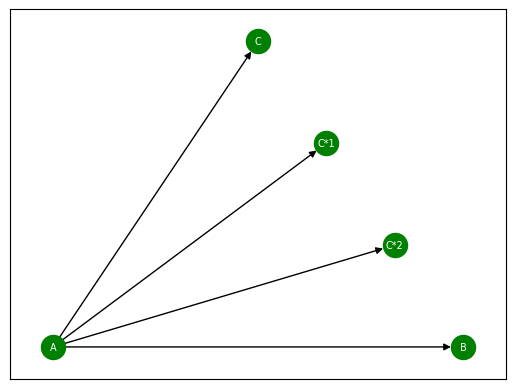

In [ ]:
res = p_to_graph("a; b; c")
expected = _create_graph(['a', 'b', 'c'], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res = p_to_graph("A->B; A->C; A->C*1; A->C*2")
expected = _create_graph(['A', 'B', 'C', 'C*1', 'C*2'], [('A','B'), ('A','C'), ('A','C*1'), ('A', 'C*2')])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

var: x


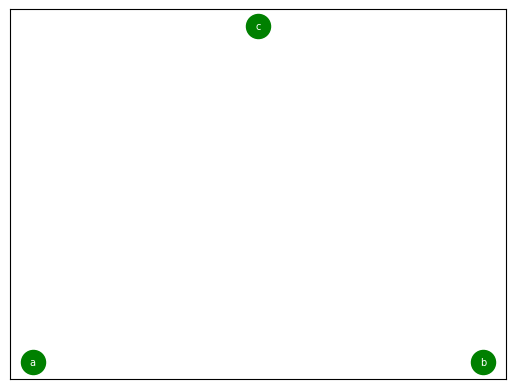

In [ ]:
res = rhs_to_graph("""a; b; c[attr={{x}}]""", match = None, render_funcs={"x": lambda m: 5})
expected = _create_graph(['a', 'b', ('c',{"attr":5})], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res = rhs_to_graph("""a; b; c[attr={{x}}]""", match = None, render_funcs={"x": lambda m: 5})
expected = _create_graph(['a', 'b', ('c',{"attr":5})], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)